In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Data Preprocessing
Locate files:

C = Cuivre / Copper / Cu
Z = Zinc / Zn
M = Methomyl

### FPCA for individual species

In [5]:
#define parameters
specie = {'E':'Erpobdella','G':'Gammarus','R':'Radix'}
specie_dim = {'E':'X','G':'Y','R':'Z'}
substances = {'Copper':[0,1,2,3],'Methomyl':[4,5,6,7],'Zinc':[8,9,10,11]}

In [6]:
#locate files and load data for each species
directory = r'D:\VP\ARTICLE2\ArticleData'
data = {s:pd.read_csv(r'{}\{}_{}_i_data.csv'.format(directory,s,specie_dim[s]),header = None) for s in specie}

In [7]:
cols = ['{}{}'.format(s,x) for s in substances for x in range(len(substances[s]))]
y = ['{}'.format(s) for s in substances for x in range(len(substances[s]))]

In [8]:
#replace df columns with species names
for s in specie:data[s].columns = cols

### Import relevant Data Structures and convert to FD Data Grids and BSplines

In [9]:
from skfda.representation.grid import FDataGrid
from skfda.representation.basis import BSplineBasis

In [10]:
#Define timestep for data and remove end data
timestep = 30
full_length = data[[*data][0]].shape[0]
n_rows = (full_length//timestep)*timestep

In [12]:
#define FDA parameters
domain_range = (0,n_rows)
order = 4
knots = np.arange(0,n_rows+timestep,timestep)
n_basis = len(knots) + order - 2

bbs = BSplineBasis(domain_range = domain_range,n_basis = n_basis,order = order,knots = knots)
knots

array([  0,  30,  60,  90, 120, 150, 180, 210, 240, 270, 300, 330, 360,
       390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720])

In [13]:
grid_points = np.arange(n_rows)
data_matrices = {s:np.transpose(np.array(data[s].iloc[:n_rows])) for s in specie}

fds = {s:FDataGrid(data_matrix=data_matrices[s],grid_points=grid_points,) for s in specie}

### Create basis functions

In [14]:
bss = BSplineBasis(domain_range = domain_range,n_basis = n_basis,order = order,knots = knots)

In [15]:
X_bss = {s:fds[s].to_basis(bss) for s in specie}

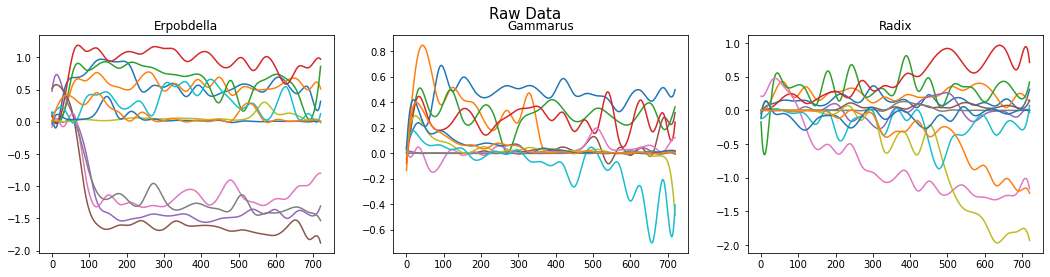

In [16]:
fig,axe = plt.subplots(1,3,figsize = (18,4))
fig.suptitle('Raw Data',fontsize = 15)
for i,s in enumerate(specie): 
    X_bss[s].plot(axes = axe[i])
    axe[i].set_title(specie[s])

## FPCA

In [17]:
from skfda.exploratory.visualization import FPCAPlot
from skfda.preprocessing.dim_reduction import FPCA

In [18]:
fpcas = {s: FPCA(n_components=2).fit(X_bss[s]) for s in specie}

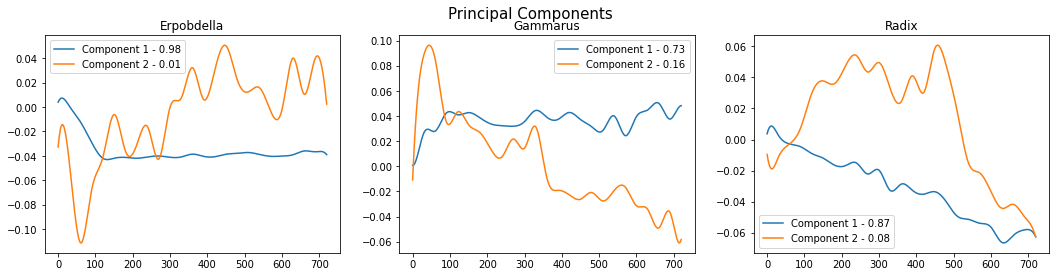

In [19]:
fig,axe = plt.subplots(1,3,figsize = (18,4))
fig.suptitle('Principal Components',fontsize = 15)
for i,s in enumerate(specie):
    fpcas[s].components_.plot(axes = axe[i])
    axe[i].legend(
        labels=['Component 1 - {:.2f}'.format(fpcas[s].explained_variance_ratio_[0]),
                'Component 2 - {:.2f}'.format(fpcas[s].explained_variance_ratio_[1])])
    axe[i].set_title(specie[s])

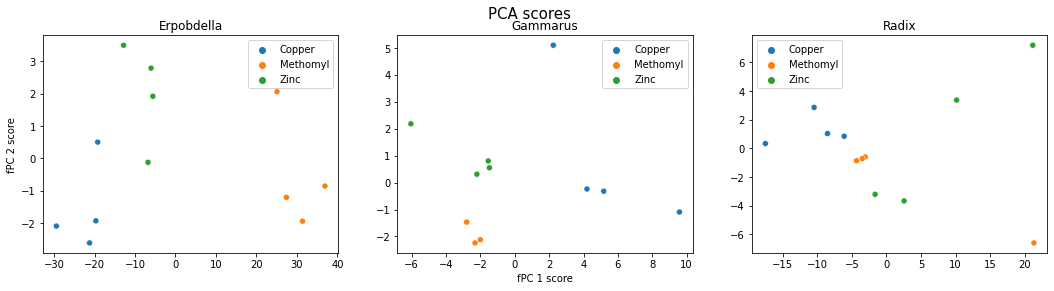

In [20]:
#Show all PCAs as FPCA scores plot
scores = {s:fpcas[s].fit_transform(X_bss[s]) for s in specie}

fig_FPCA,ax_FPCA = plt.subplots(1,3,figsize=(18,4))
fig_FPCA.suptitle('PCA scores',fontsize = 15)

ax_FPCA[1].set_xlabel("fPC 1 score")
ax_FPCA[0].set_ylabel("fPC 2 score")

for i,s in enumerate(specie):
    sns.scatterplot(x=scores[s][:, 0], y=scores[s][:, 1],hue = y,ax = ax_FPCA[i])
    ax_FPCA[i].set_title(specie[s])  

#ax_meanFPCA.tick_params(labelsize = 13)
plt.show()

## MultiVector FDA

Whilst this is possible to create multidimensional Vector grids, their combination has not yet been achieved.

In [21]:
from skfda.representation.basis import VectorValuedBasis

In [24]:
data_vector_matrix = np.transpose(np.array([np.array(data[s].iloc[:n_rows]) for s in specie]))
vector_fd = FDataGrid(data_matrix=data_vector_matrix,grid_points=grid_points,)

In [25]:
vector_bss = VectorValuedBasis([bss for i in range(3)])
vector_bss = vector_fd.to_basis(vector_bss)

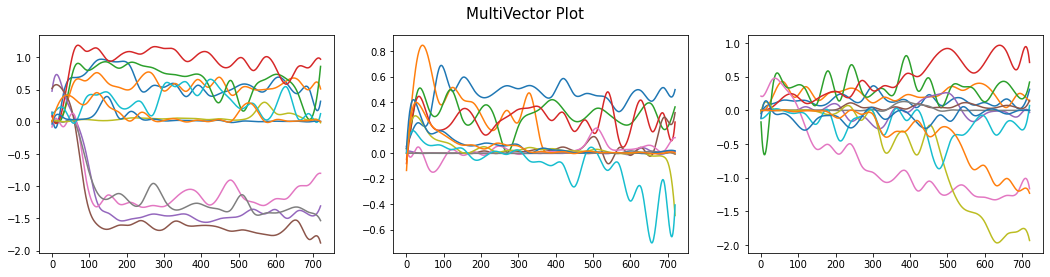

In [26]:
fig,axe = plt.subplots(1,3,figsize = (18,4))
fig.suptitle('MultiVector Plot',fontsize = 15)
vector_bss.plot(axes = axe)
plt.show()

### What appears strange here is there is not exactly the same PCA for each domain 

Perhaps there is some kind of normalisation

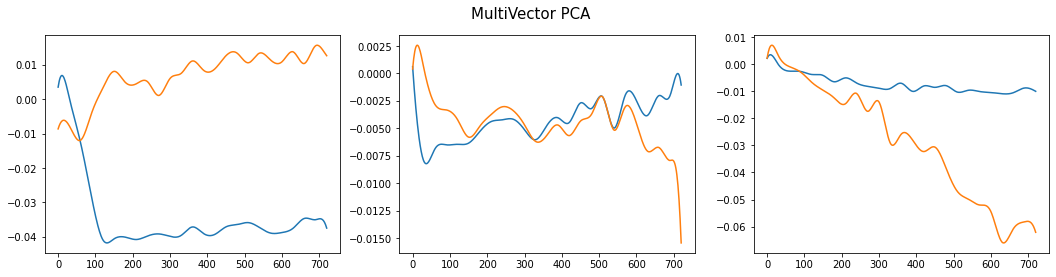

In [27]:
fig,axe = plt.subplots(1,3,figsize = (18,4))
fig.suptitle('MultiVector PCA',fontsize = 15)
vector_fpca = FPCA(n_components=2).fit(vector_bss)
vector_fpca.components_.plot(axes = axe)
plt.show()

In [28]:
### Failed PCA plot attempt
scores = vector_fpca.fit_transform(vector_bss)
scores

array([[-21.42165033,  -3.04268   ],
       [-20.94583105,  -4.07300178],
       [-23.56619932,  -6.27901777],
       [-32.58637457, -11.34252995],
       [ 30.28895403,  -9.68247521],
       [ 35.30383442, -12.08057848],
       [ 29.4180026 ,  15.29919168],
       [ 26.2831538 ,  -9.11480175],
       [ -1.64369433,  22.61188811],
       [-11.21213651,   6.23332593],
       [ -5.40140684,  -0.05166987],
       [ -4.51665191,  11.52234909]])

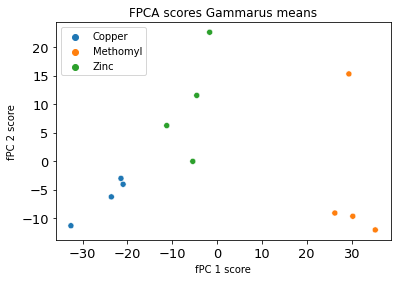

In [29]:
fig_vector_FPCA,ax_vector_FPCA = plt.subplots(figsize=(6, 4))
sns.scatterplot(x=scores[:, 0], y=scores[:, 1],hue = y,ax = ax_vector_FPCA)
ax_vector_FPCA.set_xlabel("fPC 1 score")
ax_vector_FPCA.set_ylabel("fPC 2 score")
ax_vector_FPCA.set_title("FPCA scores Gammarus means")

ax_vector_FPCA.tick_params(labelsize = 13)
plt.show()

# Clustering

**Clustering methods should be fed the smoothed data not the basis data - it must be loaded in**

In [31]:
from skfda.exploratory.visualization.clustering import (
    ClusterMembershipLinesPlot,
    ClusterMembershipPlot,
    ClusterPlot
)
from skfda.ml.clustering import FuzzyCMeans,KMeans

## Single basis clusters

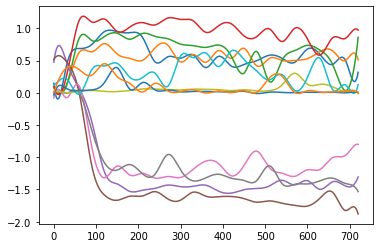

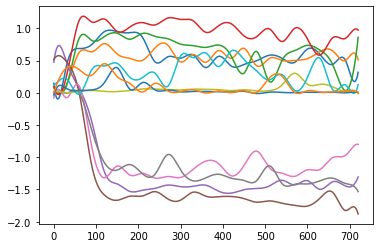

In [39]:
#Clustering unsupervised (except no. clusters)
n_clusters = 3
seed = 0

kmeans = {s:KMeans(n_clusters = n_clusters, random_state = seed).fit(X_bss[s].to_grid()) for s in specie}
for s in specie:
    print('Kmeans prediction: {}'.format(specie[s]))
    print(kmeans[s].predict(X_bss[s].to_grid()))

Kmeans prediction: Erpobdella
[1 1 1 1 2 2 0 0 1 1 1 1]
Kmeans prediction: Gammarus
[1 1 1 1 0 0 0 0 2 2 2 2]
Kmeans prediction: Radix
[2 2 2 2 2 2 0 2 1 2 2 1]


In [53]:
vector_kmean = KMeans(n_clusters = 3, random_state = seed).fit(vector_bss.to_grid())
vector_kmean.predict(vector_bss.to_grid())

array([1, 1, 1, 1, 2, 2, 0, 2, 1, 1, 1, 1])